In [1]:
from notebooks.utils import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import numpy as np

In [2]:
def get_my_cmap(cmap_name, plot_example=False):
    cmap = matplotlib.colormaps[cmap_name]
    cmap_colors = cmap(np.linspace(0, 1, 256))
    cmap_colors[:, :3] *= np.linspace(0, 1, 256).reshape(-1, 1)  # Scale RGB values by alpha
    cmap = mcolors.ListedColormap(cmap_colors)

    if plot_example:
        # Create a figure and axis
        fig, ax = plt.subplots()

        # Generate example data
        x = np.linspace(0, 1, 100)
        y = np.sin(x * np.pi)

        # Plot with the custom colormap
        cax = ax.scatter(x, y, c=y, cmap=cmap, vmin=0, vmax=1, s=70)

        # Add a colorbar
        cbar = fig.colorbar(cax)
        cbar.set_label('Value')

        # Show the plot
        plt.show()
        
    return cmap

In [3]:
#['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

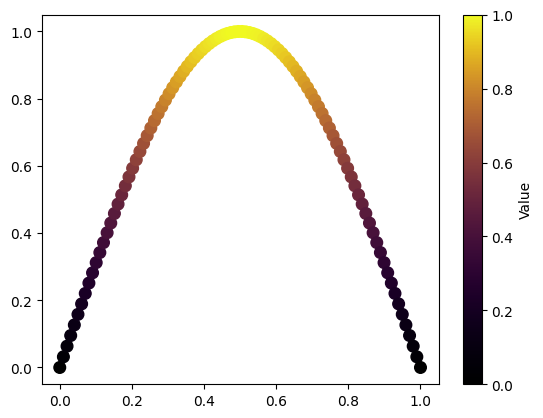

In [4]:
cmap_test = get_my_cmap('plasma', plot_example=True)

In [5]:
def get_tris_sources_helper(PARCELLATION):
    random_edf_file_path = 'S001R03.edf' 

    subjects_dir, _, trans, src_path, bem_path = get_fsaverage()

    info = get_raw(random_edf_file_path, filter=True).info # Just need one raw to get info
    src = get_src(src_path)
    fwd = get_fwd(info, trans, src_path, bem_path)

    labels = get_labels(subjects_dir, parcellation_name=PARCELLATION)

    vertices = get_vertices(src)
    tris_vertices = get_vertices_tris(src)

    sources = get_sources(src)
    tris_sources = get_sources_tris(src)

    return tris_sources, sources

def get_activation(labels, keywords):
    activation = [[None]*len(labels[0]), [None]*len(labels[1])]
    for hemi in range(2):
        for i, label in enumerate(labels[hemi]):
            if all(keyword in label.name for keyword in keywords):
                activation[hemi][i] = 1
            else:
                activation[hemi][i] = 0
    return activation

def plot_activation(keywords, labels, cmap='Blues', parcellation='HCPMMP1_combined', linewidth=0.02, show_title=False, save_plot=True):

    tris_sources, sources = get_tris_sources_helper(parcellation)

    activation = get_activation(labels, keywords)

    values = activity_to_source_values(activation, labels, sources)
    tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=linewidth, shade=False,
                            antialiased=True, edgecolor='white', cmap=cmap)

    lh_mesh.set_array(tris_values[0])
    #fig.colorbar(lh_mesh, shrink=0.5)

    rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=linewidth, shade=False,
                            antialiased=True, edgecolor='white', cmap=cmap)

    rh_mesh.set_array(tris_values[1])
    #fig.colorbar(rh_mesh, shrink=0.5)

    ax.set_xlim(-0.06, 0.06)
    ax.set_ylim(-0.08, 0.04)
    ax.set_zlim(-0.04, 0.09)
    ax.set_box_aspect([1,1,1])
    ax.view_init(60, -45)
    ax.axis("off")

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    if show_title:
        plt.title(keywords[0] + ' ' + keywords[1], fontsize=20)

    if save_plot:
        path = '/home/williamtheodor/Documents/DL for EEG Classification/BENDR-XAI/visulizations/concept illustrations/'
        plt.savefig(path + keywords[0] + '_' + keywords[1] + '_activity.png', dpi=300, bbox_inches='tight', pad_inches=-.4)
        
    plt.tight_layout()
    plt.show()

In [6]:
PARCELLATION = 'HCPMMP1_combined' #"aparc.a2009s"
subjects_dir, _, trans, src_path, bem_path = get_fsaverage()

labels = get_labels(subjects_dir, parcellation_name=PARCELLATION)
label_names = [label.name for label in np.array(labels).flatten()]

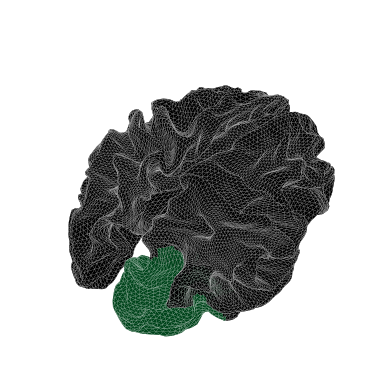

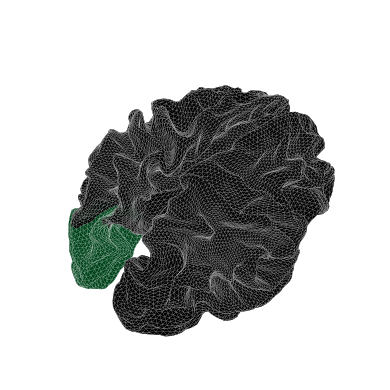

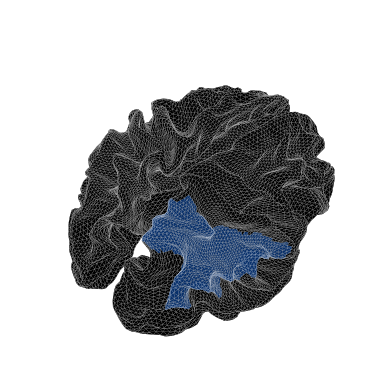

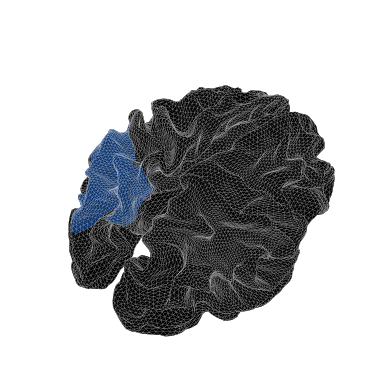

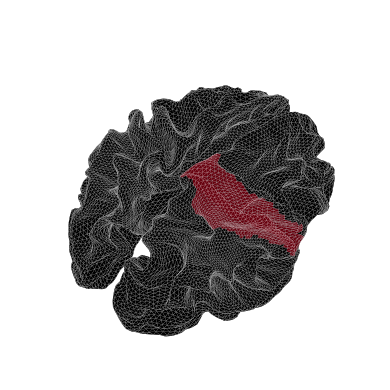

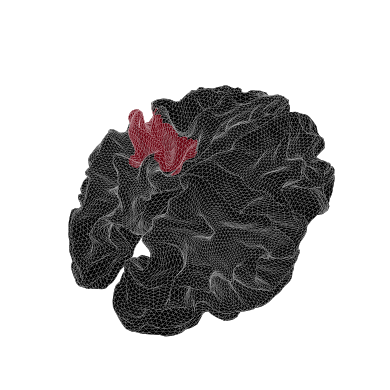

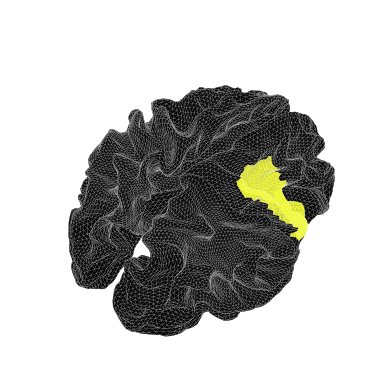

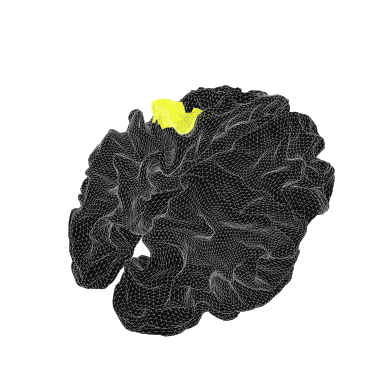

In [7]:
list_of_activations = [
    {'keywords': ['Visual', 'rh'], 'cmap': get_my_cmap('Greens')},
    {'keywords': ['Visual', 'lh'], 'cmap': get_my_cmap('Greens')},
    {'keywords': ['Parietal', 'rh'], 'cmap': get_my_cmap('Blues')},
    {'keywords': ['Parietal', 'lh'], 'cmap': get_my_cmap('Blues')},
    {'keywords': ['Motor', 'rh'], 'cmap': get_my_cmap('Reds')},
    {'keywords': ['Motor', 'lh'], 'cmap': get_my_cmap('Reds')},
    {'keywords': ['Premotor', 'rh'], 'cmap': get_my_cmap('plasma')},
    {'keywords': ['Premotor', 'lh'], 'cmap': get_my_cmap('plasma')},
]

for activation in list_of_activations:
    plot_activation(keywords=activation['keywords'], labels=labels, cmap=activation['cmap'], parcellation=PARCELLATION, linewidth=0.08, show_title=False, save_plot=True)